In [1]:
from i10_bluesky.devices.rasor.detectorSlits import *
from i10_bluesky.devices.scalerCard import ScaleCard
from i10_bluesky.devices.pimteAD import *
from i10_bluesky.plans.rasor.pimte_plans import AdPlan
from ophyd_async.core import DeviceCollector
from ophyd_async.core.async_status import AsyncStatus
from ophyd_async.core.detector import TriggerInfo, DetectorTrigger
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import RunEngine
from bluesky.plans import count, scan  
from bluesky.plan_stubs import *
from bluesky.preprocessors import contingency_wrapper
from ophyd.sim import det1
from bluesky.utils import *
from bluesky.utils import Msg
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps
from bluesky.protocols import *
from dodal.beamlines.beamline_utils import set_directory_provider
from ophyd_async.core._providers import StaticDirectoryProvider
import asyncio
import os
loop = asyncio.get_event_loop()
bec = BestEffortCallback()
RE = RunEngine({})


In [2]:
df =  StaticDirectoryProvider("/dls/i10/data/2024/cm37251-2/processing/", "i10-")

with DeviceCollector():
    ds = DetectorSlits('ME01D-MO-APTR',name = "detSlits")
        
pimte = HDFStatsPimte(
"BL10I-EA-PIMTE-01:",
df,
"pimte",)
loop.create_task(pimte.connect())
ti = TriggerInfo(1, DetectorTrigger.internal,6,0.003)

In [ ]:
result = loop.create_task(pimte.drv.acquire_time.read())

In [8]:
RE(count([pimte]),bec)



Transient Scan ID: 5     Time: 2024-04-08 15:01:11
Persistent Unique Scan ID: '67e67a23-3814-4f18-8e7c-d85f0a0ad13a'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 15:01:14.7 |
+-----------+------------+
generator count ['67e67a23'] (scan num: 5)





('67e67a23-3814-4f18-8e7c-d85f0a0ad13a',)

In [10]:
pimtePlan = AdPlan(pimte)



Transient Scan ID: 6     Time: 2024-04-08 15:01:43
Persistent Unique Scan ID: '4e2e2ea0-e0d0-4fa0-aba5-a5e50d7d561e'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 15:01:46.9 |
+-----------+------------+
generator tiggerImg ['4e2e2ea0'] (scan num: 6)





('4e2e2ea0-e0d0-4fa0-aba5-a5e50d7d561e',)

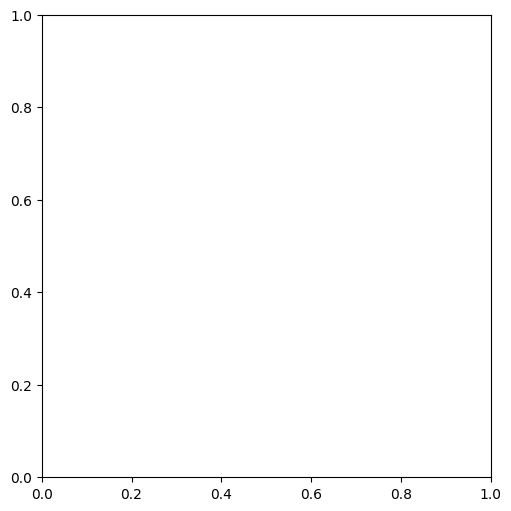

In [11]:
RE(AdPlan.tiggerImg(pimte,0.002),bec)



Transient Scan ID: 8     Time: 2024-04-08 15:02:00
Persistent Unique Scan ID: '86af960e-408d-4a70-8ccb-9f415b9b6f5c'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
+-----------+------------+
generator takeImg ['86af960e'] (scan num: 8)





('86af960e-408d-4a70-8ccb-9f415b9b6f5c',)

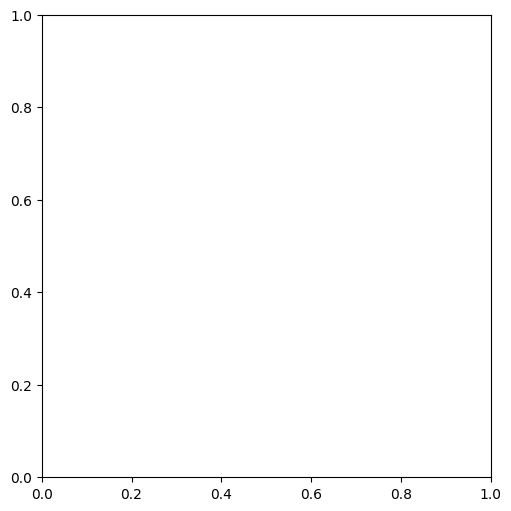

In [13]:
RE(pimtePlan.takeImg(), bec)

In [16]:
RE(pimtePlan.takeImg(exposure = 0.003, n_img = 1))

('623383fa-107d-406a-bf22-b329b484482b',)

In [ ]:
asyncio.create_task(pimte.writer.open())

In [ ]:
asyncio.wait_for(pimte.trigger(), timeout =10)

In [ ]:
async def test():
    aw = await asyncio.gather(pimte.prepare(ti))
    await asyncio.wait_for(aw, timeout = 5)    

In [ ]:
asyncio.gather(pimtePlan.setTemp(16))

In [ ]:
result = asyncio.create_task(test())

In [ ]:
print(k)

In [ ]:
RE((pimtePlan.setTemp(17)))
RE((pimtePlan.setAdcSpeed(pimte.drv.SpeedMode.adc_200Khz)))

In [ ]:
def doublePlan():
    yield from pimtePlan.setTemp(19)
    yield from pimtePlan.setAdcSpeed(pimtePlan.det.drv.SpeedMode.adc_2Mhz)

In [ ]:
RE(doublePlan())


In [ ]:
RE(AdPlan.tiggerImg(pimtePlan.det,0.02))

In [17]:

def takeImg2(det,value):  
    grp = short_uid('takeImg')
    yield Msg("open_run")
    yield from stage(det,  group = grp, wait = True)
    yield from kickoff(det, group = grp, wait = True)
    yield from prepare(det, ti, group=grp, wait = True)
    yield from complete(det, group = grp, wait = True)
    #yield from wait(group=grp)
    yield Msg("unstage", det, group = grp, wait = True)
    yield Msg("close_run")

In [20]:
RE(takeImg2(pimte, ti))

('e24c8316-cde4-4eb9-94ba-b5ac86ca6adb',)

In [ ]:
def tiggerImg3(dets, value):
    yield Msg("set", pimte.drv.acquire_time, value)
    @bpp.stage_decorator([dets])
    @bpp.run_decorator()
    def innerTiggerImg():
        return (yield from bps.trigger_and_read([dets]))
    return (yield from innerTiggerImg())

In [21]:
from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

ModuleNotFoundError: No module named 'databroker'

In [21]:
k = asyncio.create_task(pimte.writer.hdf.file_path.get_value())


In [22]:
k

<Task finished name='Task-208' coro=<SignalR.get_value() done, defined at /venv/lib/python3.11/site-packages/ophyd_async/core/signal.py:28> result='/dls/i10/dat...2/processing/'>

In [32]:
pimte._writer._directory_provider().prefix

'i10-'